# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

# Load Libraries

In [1]:
import h5py
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

print(os.listdir("./Input/train"))

['images_training.h5', 'labels_training.h5']


# Load Data

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [3]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# Principal Component Analysis


<div style="text-align: right"> Sourced: https://stats.stackexchange.com/questions/125172/pca-on-train-and-test-datasets-should-i-run-one-pca-on-traintest-or-two-separa </div>
<div style="text-align: right"> https://towardsdatascience.com/pca-with-numpy-58917c1d0391 </div>
<div style="text-align: right"> https://stackoverflow.com/questions/10818718/principal-component-analysis </div>



## Computing the Eigenvectors and Eigenvalues


In [4]:
data = data_train
data = data - np.mean(data, axis=0)
print(data.shape)
covariance_matrix = np.cov(data.T)
#print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)
print("First 20 Eigenvalues: \n", eig_val[:20], "\n")

(30000, 784)
First 20 Eigenvalues: 
 [19.8611004  12.10997382  4.1078177   3.3719857   2.61461635  2.35693788
  1.61184549  1.28149922  0.92593176  0.89463432  0.67365696  0.62224642
  0.52434522  0.44943814  0.41495554  0.4023021   0.37964251  0.36276613
  0.31522305  0.31177036] 



## Picking Principal Components


In [5]:
variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)     
print("First 40 Variance Explained: \n", variance_explained[:40], "\n") 

cumulative_variance_explained = np.cumsum(variance_explained)
print("First 40 Cummulative Variance Explained: \n", cumulative_variance_explained[:40], "\n") 


First 40 Variance Explained: 
 [29.077053310731294, 17.72924699012503, 6.013928330120427, 4.936655363514209, 3.8278512994969107, 3.4506048031981504, 2.3597744497586266, 1.876140819639972, 1.3555828542550032, 1.309762764368793, 0.986247442813638, 0.9109813631941975, 0.7676520274675228, 0.6579865468252284, 0.6075033144694078, 0.5889784249457763, 0.5558043304416028, 0.5310969638898528, 0.46149293588082124, 0.4564381199172578, 0.4308744701286418, 0.40531709542942435, 0.38528669629317547, 0.3716535631426292, 0.3638427643695209, 0.3535698643776627, 0.3333803525997783, 0.32046338486500503, 0.30885648457342885, 0.2907937961412205, 0.27789465458325713, 0.26788497551420526, 0.2633124356331287, 0.2552132198846887, 0.24738286446302726, 0.23658653951117362, 0.2300137223183935, 0.2251246644898989, 0.21946821942021616, 0.21117399184062252] 

First 40 Cummulative Variance Explained: 
 [29.07705331 46.8063003  52.82022863 57.75688399 61.58473529 65.0353401
 67.39511455 69.27125537 70.62683822 71.936600

### Plot Cumulative explained variance to find elbow point

Text(0.5, 1.0, 'Explained variance vs Number of components')

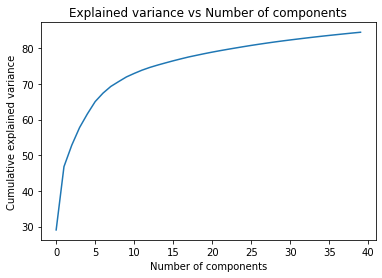

In [6]:

sns.lineplot(x = np.arange(40), y=cumulative_variance_explained[:40])
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")

## Project Data Onto Lower-Dimensional Linear Subspace

### Project onto training data

In [7]:
projection_matrix = (eig_vec.T[:][:40]).T
X_pca = data.dot(projection_matrix)

print(X_train_pca.shape)

NameError: name 'X_train_pca' is not defined

### Project on to test data

In [ ]:
data = data_test
data = data - np.mean(data, axis=0)
X_test_pca = data.dot(projection_matrix)
print(X_test_pca.shape)

# Cross Validation
10-Fold cross validation between 8-15 k-nearest neigbhours.

In [5]:
%%time

k = 10 # number of folds for cv
indices_cv = KFold(n_splits=10, random_state=None, shuffle=False) # indices for the k-folds
pca_scores = []
n_comp_list = np.arange(8, 15)
for K in n_comp_list:
    knn = KNeighborsClassifier(n_neighbors=K)
    score = 0
    count = 1
    for train_index, test_index in indices_cv.split(X_train_pca):
        print("comp", K, " fold", count)
        count+=1
        test_id = test_index
        train_id = train_index
        y_true = label_train[test_id]
        model = knn.fit(X_train_pca[train_id], label_train[train_id])
        score += model.score(X_train_pca[test_index], label_train[test_id])
    pca_scores.append(score/k)
pca_scores = np.array(pca_scores)


comp 8  fold 1
comp 8  fold 2
comp 8  fold 3
comp 8  fold 4
comp 8  fold 5
comp 8  fold 6
comp 8  fold 7
comp 8  fold 8
comp 8  fold 9
comp 8  fold 10
comp 9  fold 1
comp 9  fold 2
comp 9  fold 3
comp 9  fold 4
comp 9  fold 5
comp 9  fold 6
comp 9  fold 7
comp 9  fold 8
comp 9  fold 9
comp 9  fold 10
comp 10  fold 1
comp 10  fold 2
comp 10  fold 3
comp 10  fold 4
comp 10  fold 5
comp 10  fold 6
comp 10  fold 7
comp 10  fold 8
comp 10  fold 9
comp 10  fold 10
comp 11  fold 1
comp 11  fold 2
comp 11  fold 3
comp 11  fold 4
comp 11  fold 5
comp 11  fold 6
comp 11  fold 7
comp 11  fold 8
comp 11  fold 9
comp 11  fold 10
comp 12  fold 1
comp 12  fold 2
comp 12  fold 3
comp 12  fold 4
comp 12  fold 5
comp 12  fold 6
comp 12  fold 7
comp 12  fold 8
comp 12  fold 9
comp 12  fold 10
comp 13  fold 1
comp 13  fold 2
comp 13  fold 3
comp 13  fold 4
comp 13  fold 5
comp 13  fold 6
comp 13  fold 7
comp 13  fold 8
comp 13  fold 9
comp 13  fold 10
comp 14  fold 1
comp 14  fold 2
comp 14  fold 3
comp 1

## Visualisation of Cross Validaiton

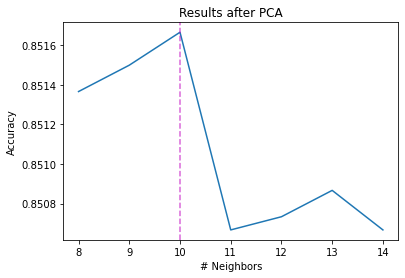

In [6]:
fig, ax = plt.subplots()
n_comp_list = np.arange(8, 15)
ax.plot(n_comp_list, pca_scores)
ax.axvline(n_comp_list[np.argmax(pca_scores)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(n_comp_list)
ax.set_title('Results after PCA')
plt.show()

# Prediciton on Tuned Model

In [22]:
%%time

y_true = label_test
knn = KNeighborsClassifier(n_neighbors=np.argmax(pca_scores), algorithm="kd_tree")
knn.fit(X_train_pca, label_train)
y_pred = knn.predict(X_test_pca)
print(knn.score(X_test_pca[:2000], label_test))

0.82
CPU times: user 3.4 s, sys: 64.9 ms, total: 3.46 s
Wall time: 4.9 s


In [21]:
y_true = np.array(y_true)
print(y_true[:10])
y_pred = np.array(y_pred)
print(y_pred[:10])
np.sum(y_true == y_pred[:2000])/len(y_true)

[1 8 1 8 4 0 4 5 3 1]
[1 8 1 8 4 0 6 9 3 1]


0.82